# **Music Listening and Music Making During the Coronavirus: Descriptive Statistics**

LW + LF 

In [1]:
import numpy as np, pandas as pd, os, sys, itertools, re, warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings(action='ignore')
#os.chdir("/Users/home/Desktop/Research/Coronavirus/Public GitHub")
%run Coronavirus_Music_Functions.ipynb

In [22]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
with open("/Users/home/Desktop/Research/Coronavirus/Public GitHub/cleaned_data.csv", 
          encoding="utf8", errors='ignore') as file:
    data = pd.read_csv(file)
    
data.shape

(5113, 232)

In [3]:
data.shape

(5113, 233)

In [8]:
demographics = [col for col in data.columns if 'Demographics_' in col]

In [5]:
def temp_df(group_col, col_list, df):
    # find instances of where "1" is in a cell in the dataframe
    df = df.loc[:,[group_col]+col_list].reset_index(drop=True)
    row_dict = dict(zip(df.index, df[group_col]))
    
    # find instances of where "1" is in a cell in the dataframe
    row, col = np.where(df.values == 1)
    
    # replace the column index with the column name
    colname = df.columns[col]
    
    # create dataframe of row number (corresponding to person) and which column they responded '1' to
    vals = pd.DataFrame()
    vals['row'] = row
    vals['cols'] = colname
    vals['cols'] = vals['cols'].replace(r'^.*-', '', regex=True)
    
    vals = vals.set_index('row') # TODO confused what's going on with the row labels.. 

    vals['group'] = vals.index.map(row_dict)
    
    return vals

def make_grouped_df(group_col, df, tmp):
    # create dictionary of the number of participants from each group in the
    # group_col (e.g., if group_col = country, how many participants are 
    # in each country?)
    val_counts = pd.DataFrame(df[group_col].value_counts(dropna=False))
    keys = val_counts.index.tolist()
    values = val_counts[group_col].tolist()
    group_dict = dict(zip(keys, values))

    # create dataframe of proportion of people who responded to each question based on the group_dict values
    grouped_n = tmp.groupby(['group', 'cols']).size().unstack(fill_value=0)
    grouped_n['n'] = grouped_n.index.map(group_dict)
    grouped_n.loc['TOTAL']= grouped_n.sum(numeric_only=True, axis=0) # NOTE here we are taking mean of all (not dropping nan)
    grouped_perc = grouped_n.iloc[:,:-1].div(grouped_n.iloc[:,-1], axis=0).round(4)*100
    
    return grouped_n, grouped_perc

def group_numeric(data, col_list, group_col, scale_flag):
    means = pd.DataFrame(data.groupby([group_col])[col_list].mean())
    means.loc['TOTAL'] = data[col_list].mean()

    sds = pd.DataFrame(data.groupby([group_col])[col_list].std())
    sds.loc['TOTAL'] = data[col_list].std()
    
    # NOTE: we should only rescale changes if dealine with 7 point scales
    if scale_flag:
        # center the means (0 = no change now). # NOTE only relevant for 7 point scale questions. not sure in which contexts the function gets used
        perc_change = (means - 4)

        # the minimum value is -3 and the maximum value is +3 
        # we want to scale that between -1 and + 1
        # NOTE - this is not necessarily true if whole scale didn't get used. or if it is binary question
        perc_change = perc_change/3


        # change to percent -- this is now the "percent change from 0"
        # i.e., if there's a score of "-10" it means the score is 
        # 10% LESS than before coronavirus
        perc_change = perc_change * 100
        perc_change.columns = perc_change.columns + ['_change']

        new = means.merge(sds, left_index=True, right_index=True, suffixes=('_mean', '_sd')).merge(perc_change, left_index=True, right_index=True)
        new = new.reindex(sorted(new.columns), axis=1)
    
    else: 
        new = means.merge(sds, left_index=True, right_index=True, suffixes=('_mean', '_sd')) #.merge(perc_change, left_index=True, right_index=True)
        new = new.reindex(sorted(new.columns), axis=1)
        
    return new
    
    

def mean_differences(data, index_list, col_list):
    tmp = pd.DataFrame(columns=['index']+col_list)
    tmp['index']= index_list
    tmp = tmp.set_index('index')
    
    # note -- this will throw an error if there are not positive AND negative classes
    for i,c in list(itertools.product(index_list, col_list)): # NOTE - kind of confused what happening here
        pos_class = data.groupby([i])[c].mean()[1]
        neg_class = data.groupby([i])[c].mean()[0]
        
        tmp.loc[i,c] = np.subtract(pos_class, neg_class)
        
    return tmp

### Overall Stats

In [16]:
# country counts
pd.DataFrame(data['Country_Country Name'].value_counts(dropna=False))

,Country_Country Name
France,983
Italy,892
India,891
Germany,872
USA,854
UK,621


### Basic Info

In [17]:
group_col = 'Country_Country Name'
col_list = ['Demographics_COVID_Number Times Leave','Demographics_General_Age', #'Demographics_General_Gender',
            'Demographics_General_Education Years', 'Demographics_Music_Ollen']

tmp = group_numeric(data, col_list, group_col, 0)
# Wait we should not be using this function for this type of data because subtracting 4, dividing by 3 etc. doesn't make sense

# Don't need these anymore, now that we have flag for scaling / change calculation
# no_change = [c for c in tmp.columns if '_change' not in c]
# tmp[no_change].round(2)

# NOTE - is it possible to flip orientation of tables? yes 
tmp.transpose().round(2)
# why is gender in numbers - this should be categorical and we want to keep the diverse in there..
# Did this already get scrubbed over in preproc? Yes
# might be nice to redo. Also average and SD are meaningless for gender. We just want percentage

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Demographics_COVID_Number Times Leave_mean,3.21,6.74,3.18,2.91,3.23,3.23,3.76
Demographics_COVID_Number Times Leave_sd,3.56,5.71,4.81,3.71,3.22,3.68,4.44
Demographics_General_Age_mean,49.51,45.86,37.25,51.18,32.13,45.25,44.22
Demographics_General_Age_sd,17.25,12.97,13.67,17.06,11.47,14.51,16.15
Demographics_General_Education Years_mean,17.64,15.24,12.37,12.63,16.48,16.57,15.12
Demographics_General_Education Years_sd,5.22,5.94,6.84,5.30,3.63,5.50,5.93
Demographics_Music_Ollen_mean,1.91,2.03,2.90,2.08,2.03,2.11,2.17
Demographics_Music_Ollen_sd,0.78,0.81,1.64,0.76,0.99,1.18,1.11


In [26]:
# describe gender separately 
pd.DataFrame(data.groupby(['Country_Country Name'])['Demographics_General_Gender'].value_counts(dropna=False, normalize=True))
#pd.DataFrame(data.groupby(['Country_Country Name'])['Demographics_General_Gender_binary'].value_counts(dropna=False, normalize=True))

Demographics_General_Gender
Country_Country Name Demographics_General_Gender                             
France               1.0                                             0.518820
                     2.0                                             0.476094
                     NaN                                             0.004069
                     4.0                                             0.001017
Germany              1.0                                             0.518349
                     2.0                                             0.478211
                     3.0                                             0.002294
                     4.0                                             0.001147
India                2.0                                             0.558923
                     1.0                                             0.435466
                     4.0                                             0.005612
Italy                1.0                                             0.528027
                     2.0                                             0.470852
                     NaN                                             0.001121
UK                   1.0                                             0.706924
                     2.0                                             0.281804
                     4.0                                             0.008052
                     3.0                                             0.003221
USA                  1.0                                             0.571429
                     2.0                                             0.427400
                     4.0                                             0.001171

### Infected with COVID-19

In [27]:
col_list = ['Demographics_Health_COVID Contact Binary']+[c for c in data.columns if 'Infected with COVID' in c]
group_col = 'Country_Country Name'

tmp = temp_df(group_col, col_list, data)
#print(tmp.head(10))
grouped_n, grouped_perc = make_grouped_df(group_col, data, tmp)
grouped_perc.transpose()

# NOTE the binary does not seem to match up with other cols.. why.. TODO
# something is maybe going wrong in calculation somewhere? Just double checked preproc script, all cols we would want seem to be there
# (data['Demographics_Health_Infected with COVID-I Am Infected']==1)
# | (data['Demographics_Health_Infected with COVID-I Live With Someone']==1) 
#  | (data['Demographics_Health_Infected with COVID-I Have Professional Contact']==1)
#  | (data['Demographics_Health_Infected with COVID-Someone I Am Close To']==1)
#  | (data['Demographics_Health_Infected with COVID-I Am Mourning A Loss']==1), 
#  1, data['Demographics_Health_COVID Contact Binary'])
# Could it be because of way nans getting handled? 



group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Demographics_Health_COVID Contact Binary,26.45,10.09,28.62,16.03,23.35,33.14,22.96
I Am Infected,2.75,1.83,8.42,1.12,4.51,4.80,3.85
I Am Mourning A Loss,2.64,0.57,6.17,3.92,2.58,6.32,3.74
I Have Professional Contact,6.51,3.44,10.89,2.24,3.86,6.09,5.61
I Live With Someone,2.34,1.38,10.21,0.56,2.09,4.45,3.56
No Response,4.27,1.72,68.91,2.02,75.52,64.52,33.42
None,61.75,87.04,0.00,77.80,0.00,0.00,40.29
Prefer Not To Say,8.14,1.72,2.47,4.93,1.13,2.34,3.68
Someone I Am Close To,16.79,4.47,10.44,11.10,14.65,22.37,13.26


In [26]:
2.75+2.64+6.51+2.34+16.79

31.03

### Living Situation During COVID-19

In [28]:
col_list = [c for c in data.columns if c.startswith('Demographics_COVID_Living Situation')]
group_col = 'Country_Country Name'

tmp = temp_df(group_col, col_list, data) 
grouped_n, grouped_perc = make_grouped_df(group_col, data, tmp)
grouped_perc.transpose()

group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Alone,20.75,27.64,12.12,10.65,22.06,25.41,19.60
Child,30.62,26.83,44.11,23.88,28.02,33.96,31.39
Elderly,1.12,0.34,2.58,1.68,2.25,2.34,1.68
Friend,0.20,1.03,2.36,0.56,5.15,2.22,1.72
Other,0.92,0.57,1.23,6.73,0.48,0.94,1.88
Parent,7.93,9.75,43.77,16.03,26.57,15.34,19.40
Partner,62.26,56.19,55.78,63.68,49.28,56.56,57.81
Pet,25.33,20.76,7.97,19.62,19.97,30.44,20.73
Shared,0.41,1.83,2.13,1.12,5.80,2.22,2.03


### Ways Work is Affected Due to COVID-19

In [30]:
col_list = ['Demographics_COVID_Work Changed Binary']+[c for c in data.columns if c.startswith('Demographics_COVID_Ways Work Affected')]
group_col = 'Country_Country Name'

tmp = temp_df(group_col, col_list, data)
#print(tmp.head(30))
grouped_n, grouped_perc = make_grouped_df(group_col, data, tmp)
grouped_perc.transpose()
# NOTE - i find it a bit crazy that 20% of people were already working from home (still work from home).. good for them.. 
# Also not sure about this binary.. TODO

# (data['Demographics_COVID_Ways Work Affected-Now Work From Home']==1) 
#  | (data['Demographics_COVID_Ways Work Affected-Reduced Hours']==1) 
#  | (data['Demographics_COVID_Ways Work Affected-Job At Risk']==1)
#  | (data['Demographics_COVID_Ways Work Affected-Lower Income']==1)
#  | (data['Demographics_COVID_Ways Work Affected-Lost Job']==1),

group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Demographics_COVID_Work Changed Binary,39.37,41.40,73.51,39.57,58.78,59.25,51.38
Homeschool Children,11.70,7.34,7.41,17.94,14.01,6.44,10.70
Job At Risk,1.32,5.85,16.16,5.72,5.48,5.85,6.71
Lost Job,2.75,4.59,16.50,8.18,9.34,11.12,8.61
Lower Income,11.39,15.94,30.30,16.48,19.32,15.93,18.07
Now Work From Home,18.41,16.28,39.28,9.42,30.76,30.80,23.68
Reduced Hours,11.70,11.01,23.79,10.87,10.47,16.51,14.20
Still Go To Work,32.96,42.32,13.58,23.77,17.87,21.31,25.80
Still Work From Home,22.18,17.43,25.59,24.22,19.32,21.78,21.90


### Emotions

In [31]:
col_list = ['Demographics_Health_General Health', 'Demographics_Health_Arousal',
            'Demographics_Health_Negative Valence','Demographics_Health_Positive Valence',
            'Demographics_Health_Anxious','Demographics_Health_Bored',
            'Demographics_Health_Depressed','Demographics_Health_Lonely',
            'Demographics_Health_Stressed']

group_col = 'Country_Country Name'
new = group_numeric(data, col_list, group_col, 1)

new.columns = new.columns.str.split('Health_').str[1]
new.T.round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Anxious_change,2.08,8.71,20.21,15.41,30.32,26.63,16.26
Anxious_mean,4.06,4.26,4.61,4.46,4.91,4.80,4.49
Anxious_sd,1.58,1.19,1.70,1.42,1.36,1.32,1.47
Arousal_change,-17.19,-9.04,21.51,-20.90,-27.10,-10.17,-10.08
Arousal_mean,3.48,3.73,4.65,3.37,3.19,3.69,3.70
Arousal_sd,1.41,1.09,1.63,1.26,1.22,1.31,1.41
Bored_change,2.21,10.37,NaN,17.93,NaN,NaN,9.98
Bored_mean,4.07,4.31,NaN,4.54,NaN,NaN,4.30
Bored_sd,1.73,1.37,NaN,1.58,NaN,NaN,1.58
Depressed_change,-17.80,10.85,9.93,-2.75,19.02,15.44,4.64


In [33]:
# mean difference in emotion scores between people who said 'yes' and 'no' to the following work situations
col_list = ['Demographics_Health_General Health', 'Demographics_Health_Arousal',
            'Demographics_Health_Negative Valence','Demographics_Health_Positive Valence',
            'Demographics_Health_Anxious','Demographics_Health_Bored',
            'Demographics_Health_Depressed','Demographics_Health_Lonely',
            'Demographics_Health_Stressed']

index_list = [col for col in demographics if col.startswith('Demographics_COVID_Ways Work Affected') and
              'No Response' not in col]

tmp = mean_differences(data, index_list, col_list)
tmp.columns = tmp.columns.str.split('Health_').str[1]
tmp.index = tmp.index.str.split('-').str[1]
tmp.round(2)
# NOTE: wouldn't it be better to also have these in percent change (rather than mean diffs)? 
# but maybe we don't end up using this at all.

,General Health,Arousal,Negative Valence,Positive Valence,Anxious,Bored,Depressed,Lonely,Stressed
index,,,,,,,,,
Homeschool Children,-0.134337,-0.183751,0.0441929,-0.218432,0.0905374,-0.0340734,-0.0611161,-0.192632,0.017701
Job At Risk,0.162568,0.0693702,0.458982,0.145759,0.561566,0.241675,0.588852,0.557144,0.559406
Lost Job,0.17711,0.147189,0.353928,0.196187,0.460997,0.417742,0.517345,0.329387,0.483363
Lower Income,0.0860386,-0.00213847,0.256062,0.0595841,0.359494,0.112081,0.45823,0.375862,0.346011
Now Work From Home,0.273984,0.300384,0.0441438,0.327125,0.179243,0.213053,0.2041,0.192715,0.186907
Reduced Hours,0.280035,0.402667,0.119851,0.454863,0.21587,0.111486,0.369151,0.260358,0.182768
Still Go To Work,-0.0110763,0.0942662,-0.123275,0.0449092,-0.240579,-0.226523,-0.2006,-0.152434,-0.123355
Still Work From Home,0.0858585,0.185412,-0.0567193,0.195583,-0.0428414,-0.152958,-0.0541715,0.0104104,-0.0834444


### Activities

In [34]:
col_list = [col for col in data.columns if col.startswith('Activities_')]
group_col = 'Country_Country Name'

new = group_numeric(data, col_list, group_col, 1)
new.columns = new.columns.str.split('Activities_').str[1]
new.transpose().round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Call People_change,31.20,22.91,46.35,26.46,55.25,46.14,37.03
Call People_mean,4.94,4.69,5.39,4.79,5.66,5.38,5.11
Call People_sd,1.45,1.27,1.72,1.57,1.32,1.38,1.50
Cleaning_change,28.66,14.93,53.06,29.21,39.97,38.73,33.64
Cleaning_mean,4.86,4.45,5.59,4.88,5.20,5.16,5.01
Cleaning_sd,1.33,1.05,1.62,1.40,1.34,1.41,1.41
Cooking_change,25.63,17.29,41.27,22.30,33.93,37.42,29.28
Cooking_mean,4.77,4.52,5.24,4.67,5.02,5.12,4.88
Cooking_sd,1.31,1.07,1.61,1.42,1.27,1.36,1.38
Crafting_change,16.18,8.95,19.61,13.97,11.09,14.78,14.25


### Hypotheses

In [35]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Music Listening_Hypotheses')]
listening = group_numeric(data, col_list, group_col, 0) #NOTE: does not make sense to use change score here because there is no before / after. The middle of the scale was just agree / disagree
listening.columns = listening.columns.str.split('Hypotheses_').str[1]

listening.transpose().round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Feel Connected to Others_mean,3.68,3.56,5.50,4.03,4.14,4.55,4.24
Feel Connected to Others_sd,1.54,1.72,1.40,1.70,1.65,1.54,1.72
Helps Me Cope_mean,4.29,3.87,5.58,4.86,4.93,4.94,4.73
Helps Me Cope_sd,1.55,1.79,1.38,1.67,1.47,1.45,1.65
Serve as Social Interaction_mean,3.62,3.52,5.48,3.80,4.09,4.52,4.17
Serve as Social Interaction_sd,1.62,1.75,1.45,1.80,1.72,1.61,1.79


In [36]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Making Music_Hypotheses')]
performance = group_numeric(data, col_list, group_col, 0) # NOTE: same here
performance.columns = performance.columns.str.split('Hypotheses_').str[1]

performance.transpose().round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Feel Connected to Others_mean,3.79,3.56,5.39,4.19,3.83,4.36,4.35
Feel Connected to Others_sd,1.44,1.86,1.50,1.76,1.59,1.70,1.75
Helps Me Cope_mean,3.80,3.80,5.56,4.76,4.53,4.64,4.66
Helps Me Cope_sd,1.44,1.87,1.42,1.74,1.61,1.72,1.73
Serve as Social Interaction_mean,4.32,3.41,5.45,3.93,3.86,4.27,4.37
Serve as Social Interaction_sd,1.47,1.83,1.48,1.79,1.70,1.78,1.79


In [37]:
change_cols = [c for c in listening if '_mean' in c] #'_change' in c] # NOTE using change doesn't make sense
listen_minus_perform = listening - performance
listen_minus_perform[change_cols].transpose().round(2)
# compare means instead. Will be negative if greater value for performance

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Feel Connected to Others_mean,-0.11,0.00,0.10,-0.17,0.31,0.19,-0.11
Helps Me Cope_mean,0.49,0.08,0.02,0.10,0.40,0.30,0.07
Serve as Social Interaction_mean,-0.70,0.11,0.03,-0.13,0.23,0.26,-0.20


### Functions

In [38]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Music Listening_Functions')]
listening = group_numeric(data, col_list, group_col, 1)
listening.columns = listening.columns.str.split('Functions_').str[1]

listening.transpose().round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Creates a Personal Space_change,10.96,12.92,49.03,20.13,28.67,31.28,25.21
Creates a Personal Space_mean,4.33,4.39,5.47,4.60,4.86,4.94,4.76
Creates a Personal Space_sd,1.16,1.08,1.51,1.45,1.32,1.30,1.37
Enables Me to Vent Negative Emotions_change,20.14,14.44,46.55,32.40,22.60,25.95,27.13
Enables Me to Vent Negative Emotions_mean,4.60,4.43,5.40,4.97,4.68,4.78,4.81
Enables Me to Vent Negative Emotions_sd,1.23,1.10,1.58,1.43,1.31,1.34,1.37
Energizes Me_change,21.58,20.00,54.21,37.02,33.17,34.36,33.27
Energizes Me_mean,4.65,4.60,5.63,5.11,5.00,5.03,5.00
Energizes Me_sd,1.22,1.13,1.43,1.39,1.30,1.29,1.34
Feel Connected to My Culture_change,5.77,3.93,47.55,9.41,8.91,22.72,16.56


In [39]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Making Music_Functions')]
performance = group_numeric(data, col_list, group_col,1)
performance.columns = performance.columns.str.split('Functions_').str[1]

performance.transpose().round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Creates a Personal Space_change,11.90,15.86,48.51,22.94,23.01,29.88,28.73
Creates a Personal Space_mean,4.36,4.48,5.46,4.69,4.69,4.90,4.86
Creates a Personal Space_sd,1.18,1.17,1.43,1.48,1.25,1.31,1.38
Enables Me to Vent Negative Emotions_change,21.34,17.32,50.16,35.30,22.90,27.68,31.46
Enables Me to Vent Negative Emotions_mean,4.64,4.52,5.50,5.06,4.69,4.83,4.94
Enables Me to Vent Negative Emotions_sd,1.30,1.23,1.44,1.54,1.31,1.35,1.42
Energizes Me_change,25.07,21.61,53.78,41.13,24.93,31.65,35.26
Energizes Me_mean,4.75,4.65,5.61,5.23,4.75,4.95,5.06
Energizes Me_sd,1.23,1.15,1.35,1.47,1.29,1.28,1.35
Feel Connected to My Culture_change,9.84,10.82,49.22,17.09,7.02,23.33,23.12


In [40]:
change_cols = [c for c in listening if '_change' in c] 
# NOTE does it make sense to look at diffs in change percents? Or would it be better to look at means?
# because changes could already be neg or positive. and then we lose the ability to know whether the sign is about listening vs. playing
# but maybe I am being slow.. 
change_cols = [c for c in listening if '_mean' in c] 
listen_minus_perform = listening - performance
listen_minus_perform[change_cols].T.round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Creates a Personal Space_mean,-0.03,-0.09,0.02,-0.08,0.17,0.04,-0.11
Enables Me to Vent Negative Emotions_mean,-0.04,-0.09,-0.11,-0.09,-0.01,-0.05,-0.13
Energizes Me_mean,-0.10,-0.05,0.01,-0.12,0.25,0.08,-0.06
Feel Connected to My Culture_mean,-0.12,-0.21,-0.05,-0.23,0.06,-0.02,-0.20
Feel Less Lonely_mean,0.08,0.00,0.03,0.08,0.24,0.15,-0.01
Feel Like I Am Sharing My Experience_mean,-0.19,-0.22,-0.10,-0.22,0.03,-0.01,-0.23
Feel Like I Have Company_mean,-0.13,-0.11,-0.02,-0.21,0.09,0.13,-0.16
Feel Like I Understand Others_mean,-0.14,-0.13,-0.10,-0.20,0.07,-0.01,-0.20
Feel Like Part of a Bigger Group_mean,-0.11,-0.12,0.04,-0.09,0.06,0.07,-0.13
Gives Me New Perspectives_mean,-0.03,-0.14,-0.02,-0.08,0.30,0.14,-0.07


### Situations

In [41]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Music Listening_Situations')]
listening = group_numeric(data, col_list, group_col,1)
listening.columns = listening.columns.str.split('Situations_').str[1]

listening.T.round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Alone_change,15.73,14.55,43.98,20.05,29.61,27.65,25.00
Alone_mean,4.47,4.44,5.32,4.60,4.89,4.83,4.75
Alone_sd,1.26,1.08,1.67,1.46,1.31,1.34,1.40
Dining_change,-3.77,3.02,13.90,-9.05,-2.79,5.51,1.24
Dining_mean,3.89,4.09,4.42,3.73,3.92,4.17,4.04
Dining_sd,1.01,0.82,1.80,1.25,1.04,1.21,1.26
Doing Nothing Else_change,10.80,8.30,40.35,10.83,25.12,24.92,19.76
Doing Nothing Else_mean,4.32,4.25,5.21,4.33,4.75,4.75,4.59
Doing Nothing Else_sd,1.21,0.95,1.66,1.39,1.25,1.31,1.36
Evening_change,-3.54,2.60,33.21,-4.61,7.33,15.66,8.37


In [58]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Making Music_Situations')]
performance = group_numeric(data, col_list, group_col, 1)
performance.columns = performance.columns.str.split('Situations_').str[1]

performance.T.round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Balconies_change,-5.21,0.51,23.51,-7.43,-1.88,9.43,6.11
Balconies_mean,3.84,4.02,4.71,3.78,3.94,4.28,4.18
Balconies_sd,0.86,0.85,1.74,1.19,0.76,1.13,1.26
Dance Alone_change,0.34,1.33,26.55,-1.72,12.04,15.57,12.09
Dance Alone_mean,4.01,4.04,4.80,3.95,4.36,4.47,4.36
Dance Alone_sd,1.12,0.97,1.76,1.43,1.20,1.29,1.41
Dance Internet_change,-6.05,-1.03,24.26,-5.80,1.94,10.03,7.00
Dance Internet_mean,3.82,3.97,4.73,3.83,4.06,4.30,4.21
Dance Internet_sd,0.79,0.82,1.70,1.07,0.91,1.11,1.24
Dance Together_change,-2.94,-2.77,21.88,-8.33,8.28,9.08,7.18


### Music Listening Formats

In [42]:
group_col = 'Country_Country Name'
col_list = [col for col in data.columns if col.startswith('Music Listening_Formats')]
listening = group_numeric(data, col_list, group_col, 1)
listening.columns = listening.columns.str.split('Formats_').str[1]

listening.T.round(2)

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Always Available Programs_change,-3.42,NaN,19.48,-1.33,2.30,13.11,6.10
Always Available Programs_mean,3.90,NaN,4.58,3.96,4.07,4.39,4.18
Always Available Programs_sd,0.89,NaN,1.80,1.17,1.02,1.11,1.28
Free Livestreams_change,3.30,NaN,35.79,3.73,17.02,23.12,16.41
Free Livestreams_mean,4.10,NaN,5.07,4.11,4.51,4.69,4.49
Free Livestreams_sd,1.05,NaN,1.67,1.27,1.21,1.24,1.36
Free Streaming Others Playlists_change,2.80,NaN,36.57,7.55,17.30,22.66,17.20
Free Streaming Others Playlists_mean,4.08,NaN,5.10,4.23,4.52,4.68,4.52
Free Streaming Others Playlists_sd,1.11,NaN,1.70,1.31,1.24,1.26,1.39
Free Streaming Own Playlists_change,5.17,NaN,35.47,4.98,17.35,23.75,17.20


### Music Engagment

In [43]:
df = data[data['Music Engagement_Engaging With Music Differently YN'] == 0].reset_index(drop=True)
print(df.groupby(group_col)['Music Engagement_Music Types-Other Genres'].unique())
print(df.groupby(group_col)['Music Engagement_Music Types-Other Musicians Composers'].unique())
print(df.groupby(group_col)['Music Engagement_Music Types-Same Musicians Composers'].unique())

# wait so this shows us that for the people who answered no to YN, there are still responses in France and Germany for other musicians / composers.. 
# makes me think there was a qualtrics filter problem just for those two survey versions...

Country_Country Name
France     [0]
Germany    [0]
India      [0]
Italy      [0]
UK         [0]
USA        [0]
Name: Music Engagement_Music Types-Other Genres, dtype: object
Country_Country Name
France     [0]
Germany    [0]
India      [0]
Italy      [0]
UK         [0]
USA        [0]
Name: Music Engagement_Music Types-Other Musicians Composers, dtype: object
Country_Country Name
France     [0]
Germany    [0]
India      [0]
Italy      [0]
UK         [0]
USA        [0]
Name: Music Engagement_Music Types-Same Musicians Composers, dtype: object


In [44]:
df = data[data['Music Engagement_Engaging With Music Differently YN'] == 1].reset_index(drop=True)
print(df.groupby(group_col)['Music Engagement_Music Types-Other Genres'].unique())
print(df.groupby(group_col)['Music Engagement_Music Types-Other Musicians Composers'].unique())
print(df.groupby(group_col)['Music Engagement_Music Types-Same Musicians Composers'].unique())

# but now here we should have responses for france and germany and we don't..
# is it possible that the binary coding got flipped?

Country_Country Name
France     [0, 1]
Germany    [0, 1]
India      [0, 1]
Italy      [0, 1]
UK         [0, 1]
USA        [0, 1]
Name: Music Engagement_Music Types-Other Genres, dtype: object
Country_Country Name
France     [0, 1]
Germany    [0, 1]
India      [0, 1]
Italy      [0, 1]
UK         [0, 1]
USA        [0, 1]
Name: Music Engagement_Music Types-Other Musicians Composers, dtype: object
Country_Country Name
France     [1, 0]
Germany    [0, 1]
India      [0, 1]
Italy      [0, 1]
UK         [0, 1]
USA        [0, 1]
Name: Music Engagement_Music Types-Same Musicians Composers, dtype: object


In [45]:
# col_list = ['Music Engagement_Engaging With Music Differently YN','Music Engagement_Diversity of Music', 
#             'Music Engagement_Interest in Others Music', 'Music Engagement_Nostalgic Music']+[c for c in data.columns if 'Music Types-' in c]
# group_col = 'Country_Country Name'

# tmp = temp_df(group_col, col_list, data)
# grouped_n, grouped_perc = make_grouped_df(group_col, data, tmp)
# grouped_perc.T

# NOTE diversity of music was on 7 point scale, as was nostalgic and interest in corona music. 
# for those we do not want to report percents and should do the mean, sd and change scores 
# (well in some cases not sure if change score applies)

group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Music Engagement_Diversity of Music,5.29,0.92,7.74,2.13,0.64,1.99,3.31
Music Engagement_Engaging With Music Differently YN,20.85,9.98,70.37,27.47,35.91,38.52,33.56
Music Engagement_Interest in Others Music,32.96,40.14,6.96,13.79,21.26,18.85,22.53
Music Engagement_Nostalgic Music,4.88,4.47,5.84,3.92,1.29,2.34,3.95
Other Genres,9.05,3.67,17.73,9.98,11.59,10.42,10.35
Other Musicians Composers,3.15,1.26,10.55,6.05,3.38,5.97,5.12
Same Musicians Composers,1.12,0.80,5.50,3.36,1.29,1.99,2.39


In [50]:
col_list = ['Music Engagement_Engaging With Music Differently YN']
group_col = 'Country_Country Name'

tmp = temp_df(group_col, col_list, data)
grouped_n, grouped_perc = make_grouped_df(group_col, data, tmp)
grouped_perc.T

group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Music Engagement_Engaging With Music Differently YN,20.85,9.98,70.37,27.47,35.91,38.52,33.56


In [55]:
# now look at ways those who said yes are engaging differently
df = data[data['Music Engagement_Engaging With Music Differently YN'] == 1].reset_index(drop=True)
col_list = [c for c in df.columns if 'Music Types-' in c]
group_col = 'Country_Country Name'
tmp = temp_df(group_col, col_list, df)
grouped_n, grouped_perc = make_grouped_df(group_col, df, tmp)
grouped_perc.T

group,France,Germany,India,Italy,UK,USA,TOTAL
cols,,,,,,,
Other Genres,43.41,36.78,25.20,36.33,32.29,27.05,30.83
Other Musicians Composers,15.12,12.64,14.99,22.04,9.42,15.50,15.27
Same Musicians Composers,5.37,8.05,7.81,12.24,3.59,5.17,7.11


In [57]:
col_list = ['Music Engagement_Diversity of Music', 'Music Engagement_Nostalgic Music']
group_col = 'Country_Country Name'
group_numeric(data, col_list, group_col, 1).transpose()


Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Music Engagement_Diversity of Music_change,1.362928,3.216374,22.661722,6.038048,14.277869,12.311558,9.717466
Music Engagement_Diversity of Music_mean,4.040888,4.096491,4.679852,4.181141,4.428336,4.369347,4.291524
Music Engagement_Diversity of Music_sd,1.097349,0.801168,1.835460,0.968801,0.930446,1.156557,1.210012
Music Engagement_Nostalgic Music_change,-0.312989,-3.600169,32.265243,5.416667,18.426843,18.063872,10.899447
Music Engagement_Nostalgic Music_mean,3.990610,3.891995,4.967957,4.162500,4.552805,4.541916,4.326983
Music Engagement_Nostalgic Music_sd,1.168488,1.349686,1.783477,1.204328,1.161226,1.291087,1.396182


In [65]:
col_list = ['Music Engagement_Interest in Others Music']
group_col = 'Country_Country Name'
group_numeric(data, col_list, group_col,0).T

Country_Country Name,France,Germany,India,Italy,UK,USA,TOTAL
Music Engagement_Interest in Others Music_mean,3.021436,2.682033,5.042527,4.150000,3.431856,3.900726,3.696315
Music Engagement_Interest in Others Music_sd,1.840056,1.734259,1.842163,1.912797,1.745964,1.951490,2.004477


In [75]:
# We might want to report these as percentage of people above 4 
print(pd.DataFrame(data['Music Engagement_Diversity of Music'].value_counts(dropna=False, normalize=True))*100)

print('\n\n', pd.DataFrame(data['Music Engagement_Interest in Others Music'].value_counts(dropna=False, normalize=True))*100)

print('\n\n', pd.DataFrame(data['Music Engagement_Nostalgic Music'].value_counts(dropna=False, normalize=True))*100)

     Music Engagement_Diversity of Music
4.0                            54.234305
5.0                            13.710151
NaN                             8.625073
6.0                             8.175240
7.0                             5.437121
1.0                             3.305300
2.0                             3.305300
3.0                             3.207510


      Music Engagement_Interest in Others Music
4.0                                  24.291023
1.0                                  22.530804
5.0                                  11.578330
7.0                                  10.385292
6.0                                  10.248386
2.0                                   8.527283
3.0                                   7.432036
NaN                                   5.006845


      Music Engagement_Nostalgic Music
4.0                         36.573440
5.0                         17.934676
NaN                         12.732251
6.0                          9.368277
3.0         

[Text(33.0, 0.5, ''), Text(0.5, 15.0, 'Age bin (years)')]

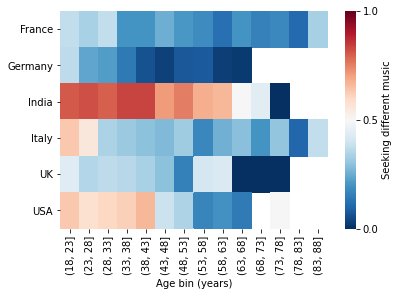

In [76]:
# YN plot
# import seaborn as sns
# data['age_bins'] = pd.cut(data['Demographics_General_Age'].values, bins=np.arange(18,92,5))
# pivotted= pd.pivot_table(data=data, index='Country_Country Name', columns='age_bins', values='Music Engagement_Engaging With Music Differently YN', aggfunc=np.mean)
# ax = sns.heatmap(pivotted, cmap='RdBu_r', center=.5, vmin=0, vmax=1, cbar_kws={"ticks":[0,.5,1], "label":'Seeking different music'})
# ax.set(xlabel='Age bin (years)', ylabel='')